In [ ]:
from itertools import combinations
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.1.Realizar el laboratorio 1 de la sección 6.5 del libro “An Introduction to Statistical Learning with
Applications in R” de Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani. Realice los
ejercicios para selección del mejor subconjunto (6.5.1), selección paso a paso hacia adelante y hacia
atrás (6.5.2) y elección entre modelos utilizando el enfoque de conjunto de validación y validación
cruzada (6.5.3). Redacte sus observaciones y conclusiones acerca de cada ejercicio, así como de las
respuestas obtenidas en consola (colocar las imágenes en su reporte).

In [ ]:
hitters = pd.read_csv('Hitters.csv', header=0, na_values='NA')
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
hitters.dropna(axis=0, inplace=True)
print(hitters.shape)
print(hitters.Salary.isnull().sum())

(263, 20)
0


In [ ]:
def score_rss(data, feature_set, endog_name):
    reg = smf.ols(endog_name + ' ~ ' + '+'.join(feature_set), data).fit()
    rss = reg.mse_resid * reg.df_resid
    return reg, (-1) * rss

def select_k_best(data, k, endog_name, score_function):
    features = data.columns.drop(endog_name)
    models = []
    scores = []
    for feature_subset in combinations(features, k):
        model, score = score_function(data, feature_subset, endog_name)
        models.append(model)
        scores.append(score)
    return models[scores.index(max(scores))]

In [ ]:
#Esta celda tarda mucho tiempo, así que se corrió de forma local
# Se paró su ejecución por eso marca error de KeyboardInterrupt
response = 'Salary'
features = hitters.columns.drop([response])

best_models = []
for k in range(1, 8+1):
    best_model = select_k_best(hitters, k, response, score_rss)
    best_models.append(best_model)
    best_features = best_model.model.exog_names
    best_features.remove('Intercept')
    print("Best {} features: {}".format(k, best_features))

Best 1 features: ['CRBI']
Best 2 features: ['Hits', 'CRBI']


KeyboardInterrupt: ignored

In [ ]:
def forward_select(data, endog_name, score_function):
    features = data.columns.drop(endog_name)
    p = len(features)

    selected_features = []
    for j in range(1, p+1):
        feature_candidates = [xj for xj in features if xj not in selected_features]
        models = []
        scores = []
        for xj in feature_candidates:
            feature_subset = selected_features + [xj]
            model, score = score_function(data, feature_subset, endog_name)
            models.append(model)
            scores.append(score)

        best_feature = feature_candidates[scores.index(max(scores))]
        selected_features += [best_feature]
        print(" Best {} features: {}".format(j, selected_features))

In [ ]:
response = 'Salary'
features = hitters.columns.drop([response])
forward_select(hitters, response, score_rss)

 Best 1 features: ['CRBI']
 Best 2 features: ['CRBI', 'Hits']
 Best 3 features: ['CRBI', 'Hits', 'PutOuts']
 Best 4 features: ['CRBI', 'Hits', 'PutOuts', 'Division']
 Best 5 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat']
 Best 6 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks']
 Best 7 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks']
 Best 8 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns']
 Best 9 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
 Best 10 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
 Best 11 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League']
 Best 12 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs']
 Best 13 features: ['CRBI'

In [ ]:
def backward_select(data, endog_name, score_function):
    features = list(data.columns.drop(endog_name))
    p = len(features)

    selected_features = features.copy() 
    for j in range(p, 0, -1):
        print("Best {} features: {}".format(j, selected_features))
        if j==1: break
        feature_candidates = list(combinations(selected_features, j-1))
        models = []
        scores = []

        for feature_subset in feature_candidates:
            model, score = score_function(data, feature_subset, endog_name)
            models.append(model)
            scores.append(score)

        selected_features = list(feature_candidates[scores.index(max(scores))])

In [ ]:
response = 'Salary'
features = hitters.columns.drop([response])

backward_select(hitters, response, score_rss)

Best 19 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 18 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 17 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 16 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors']
Best 15 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors']
Best 14 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalk

In [ ]:
def score_rss_valset(data_train, data_test, feature_set, endog_name):
    reg = smf.ols(endog_name + ' ~ ' + '+'.join(feature_set), data_train).fit()
    y_pred = reg.predict(data_test[feature_set])
    y_test = data_test[endog_name].values
    rss = ((y_pred - y_test) ** 2).sum()
    return reg, (-1) * rss

def forward_select_valset(data_train, data_test, endog_name, score_function):
    features = data_train.columns.drop(endog_name)
    p = len(features)
    high_scores = []
    best_features = []

    selected_features = [] 
    for j in range(1, p+1):
        feature_candidates = [xj for xj in features if xj not in selected_features]
        models = []
        scores = []
        for xj in feature_candidates:
            feature_subset = selected_features + [xj]
            model, score = score_function(data_train, data_test, feature_subset, endog_name)
            models.append(model)
            scores.append(score)

        highest_score = max(scores)
        high_scores.append(highest_score)
        best_feature = feature_candidates[scores.index(highest_score)]
        selected_features += [best_feature]
        best_features.append(selected_features)

    scores_df = pd.DataFrame(high_scores, index=range(1,p+1), columns=[''])
    scores_df.index.name = '# of x_j'

    best_score = max(high_scores)
    best_j = high_scores.index(best_score) + 1
    return scores_df, best_j, best_score, best_features

In [ ]:
np.random.seed(seed=51)
train_mask = np.random.choice([True, False], size = hitters.shape[0], replace = True)
test_mask = np.invert(train_mask)


In [ ]:
# Define features and response
response = 'Salary'
features = hitters.columns.drop([response])

# Run forward stepwise selection on Hitters
print("\nForward stepwise select features on training set, based on RSS. \n")
scores_valset, best_j_valset, best_score, best_features_valset = forward_select_valset(hitters[train_mask], hitters[test_mask], response, score_rss_valset)
print("Mean RSS over numbers of features:")
mean_rss_valset = scores_valset * (-1)
display(mean_rss_valset)
print("\nEl mejor modelo es el que tiene {} características:\n{}".format(best_j_valset, best_features_valset[best_j_valset-1]))


Forward stepwise select features on training set, based on RSS. 

Mean RSS over numbers of features:


,
# of x_j,
1,2.076650e+07
2,1.714363e+07
3,1.617621e+07
4,1.588872e+07
5,1.562742e+07
6,1.508433e+07
7,1.478177e+07
8,1.467281e+07
9,1.452479e+07



El mejor modelo es el que tiene 10 características:
['CRBI', 'Hits', 'Division', 'Years', 'AtBat', 'Walks', 'PutOuts', 'CWalks', 'CRuns', 'RBI', 'Errors', 'Assists', 'HmRun', 'Runs', 'NewLeague', 'League', 'CHmRun', 'CAtBat', 'CHits']


In [ ]:
_, _, _, best_features_full = forward_select_valset(hitters, hitters, response, score_rss_valset)
print("Las mejores {} caracteristicas son:\n{}".format(best_j_valset, best_features_full[best_j_valset-1]))

Las mejores 10 caracteristicas son:
['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs', 'Errors', 'HmRun', 'CHits', 'RBI', 'NewLeague', 'Years', 'CHmRun']


In [ ]:
kf = KFold(10, random_state=55)
scores_cv_list = []
for train_index, test_index in kf.split(hitters):
    scores_df, _, _, _ = forward_select_valset(hitters.iloc[train_index], hitters.iloc[test_mask], response, score_rss_valset)
    scores_cv_list.append(scores_df)
scores_cv = pd.concat(scores_cv_list, axis=1)
scores_cv.columns = range(1, 11)
scores_cv.columns.name = 'K-Fold'

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
mean_rss_cv = scores_cv.mean(axis=1) * (-1)
print(mean_rss_cv)

# of x_j
1     1.988162e+07
2     1.469190e+07
3     1.247908e+07
4     1.182492e+07
5     1.148818e+07
6     1.094343e+07
7     1.082744e+07
8     1.081981e+07
9     1.079096e+07
10    1.076345e+07
11    1.058229e+07
12    1.048883e+07
13    1.043509e+07
14    1.035223e+07
15    1.029475e+07
16    1.021250e+07
17    1.019581e+07
18    1.021123e+07
19    1.029496e+07
dtype: float64


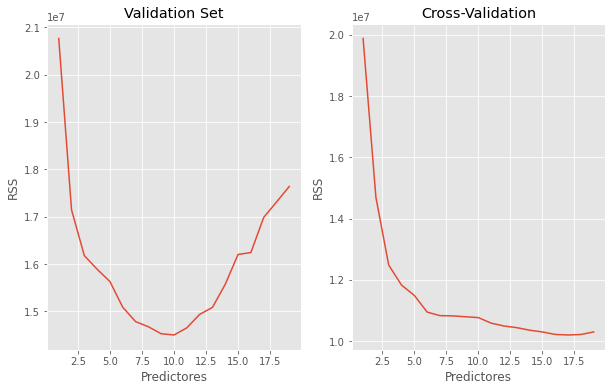

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax1 = plt.subplot(121)
plt.plot(range(1, len(features)+1), mean_rss_valset)
plt.title('Validation Set')
plt.xlabel('Predictores')
plt.ylabel('RSS')
ax2 = plt.subplot(122)
plt.plot(range(1, len(features)+1), mean_rss_cv)
plt.title('Cross-Validation')
plt.xlabel('Predictores')
plt.ylabel('RSS')
plt.show()

In [ ]:
qual_vars = ['League', 'Division', 'NewLeague']
hitters_dummies = pd.get_dummies(hitters[qual_vars])
hitters_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB


In [ ]:
dummy_vars = ['League_N', 'Division_W', 'NewLeague_N']
response = 'Salary'
y = hitters[response]
X = pd.concat([hitters.drop(qual_vars + [response], axis=1), hitters_dummies[dummy_vars]], axis=1)
features = hitters.columns.drop([response])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AtBat        263 non-null    int64
 1   Hits         263 non-null    int64
 2   HmRun        263 non-null    int64
 3   Runs         263 non-null    int64
 4   RBI          263 non-null    int64
 5   Walks        263 non-null    int64
 6   Years        263 non-null    int64
 7   CAtBat       263 non-null    int64
 8   CHits        263 non-null    int64
 9   CHmRun       263 non-null    int64
 10  CRuns        263 non-null    int64
 11  CRBI         263 non-null    int64
 12  CWalks       263 non-null    int64
 13  PutOuts      263 non-null    int64
 14  Assists      263 non-null    int64
 15  Errors       263 non-null    int64
 16  League_N     263 non-null    uint8
 17  Division_W   263 non-null    uint8
 18  NewLeague_N  263 non-null    uint8
dtypes: int64(16), uint8(3)
memory usage: 35.7 KB


2.2.Realizar el laboratorio 2 de la sección 6.6 del libro “An Introduction to Statistical Learning with
Applications in R” de Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani. Realice los
ejercicios de regresión de arista (6.6.1), y Lasso (6.6.2). Redacte sus observaciones y conclusiones
acerca de cada ejercicio, así como de las respuestas obtenidas en consola (colocar las imágenes en su
reporte).


In [ ]:
# Ridge regression on full dataset, over 100 alphas from 10 to -2
alphas = 10**np.linspace(10,-2,100)
ridge = Ridge()
coefs = []
for alpha in alphas:
    ridge.set_params(alpha=alpha*0.5)  # alpha/2 to align with R
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [ ]:
ridge_a4 = Ridge(alpha=4, normalize=True)
ridge_a4.fit(X_train, y_train)
y_pred_a4 = ridge_a4.predict(X_test)
print('\nRidge regression coefficients:\n', pd.Series(ridge_a4.coef_, index=features))
print('\nMSE = ', mean_squared_error(y_test, y_pred_a4))


Ridge regression coefficients:
 AtBat         0.098658
Hits          0.446094
HmRun         1.412107
Runs          0.660773
RBI           0.843403
Walks         1.008473
Years         2.779882
CAtBat        0.008244
CHits         0.034149
CHmRun        0.268634
CRuns         0.070407
CRBI          0.070060
CWalks        0.082795
League        0.104747
Division     -0.003739
PutOuts       0.268363
Assists       4.241051
Errors      -30.768885
NewLeague     4.123474
dtype: float64

MSE =  106216.52238005561


In [ ]:
ridge_a1e10 = Ridge(alpha=10**10, normalize=True)
ridge_a1e10.fit(X_train, y_train)
y_pred_a1e10 = ridge_a1e10.predict(X_test)
print('\nRidge regression coefficients:\n', pd.Series(ridge_a1e10.coef_, index=features))
print('\nMSE = ', mean_squared_error(y_test, y_pred_a1e10))


Ridge regression coefficients:
 AtBat        1.317464e-10
Hits         4.647486e-10
HmRun        2.079865e-09
Runs         7.726175e-10
RBI          9.390640e-10
Walks        9.769219e-10
Years        3.961442e-09
CAtBat       1.060533e-11
CHits        3.993605e-11
CHmRun       2.959428e-10
CRuns        8.245247e-11
CRBI         7.795451e-11
CWalks       9.894387e-11
League       7.268991e-11
Division    -2.615885e-12
PutOuts      2.084514e-10
Assists     -2.501281e-09
Errors      -1.549951e-08
NewLeague   -2.023196e-09
dtype: float64

MSE =  172862.23580379886


In [ ]:
ridgecv = RidgeCV(alphas=alphas*0.5, scoring='neg_mean_squared_error', normalize=True)
ridgecv.fit(X_train, y_train)
print("The best ridge regularization Alpha = ", ridgecv.alpha_)
ridge_cv = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_cv.fit(X_train, y_train)
mse = mean_squared_error(y_test, ridge_cv.predict(X_test))
print("MSE = ", mse)

The best ridge regularization Alpha =  0.5748784976988678
MSE =  99825.64896292731


In [ ]:
ridge_cv.fit(X, y)
print(pd.Series(ridge_cv.coef_, index=features))

AtBat         0.055838
Hits          0.934879
HmRun         0.369048
Runs          1.092480
RBI           0.878259
Walks         1.717770
Years         0.783515
CAtBat        0.011318
CHits         0.061101
CHmRun        0.428333
CRuns         0.121418
CRBI          0.129351
CWalks        0.041990
League        0.179957
Division      0.035737
PutOuts      -1.597699
Assists      24.774519
Errors      -85.948661
NewLeague     8.336918
dtype: float64


In [ ]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

In [ ]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
print("The best Lasso regularization Alpha = ", ridgecv.alpha_)
lasso_cv = Lasso(max_iter=10000, normalize=True, alpha=lassocv.alpha_)
lasso_cv.fit(X_train, y_train)
mse = mean_squared_error(y_test, lasso_cv.predict(X_test))
print("MSE = ", mse)

The best Lasso regularization Alpha =  0.5748784976988678
MSE =  104960.65853895503


In [ ]:
pd.Series(lasso_cv.coef_, index=features)

AtBat         0.000000
Hits          1.082446
HmRun         0.000000
Runs          0.000000
RBI           0.000000
Walks         2.906388
Years         0.000000
CAtBat        0.000000
CHits         0.000000
CHmRun        0.219367
CRuns         0.000000
CRBI          0.513975
CWalks        0.000000
League        0.368401
Division     -0.000000
PutOuts      -0.000000
Assists       0.000000
Errors      -89.064338
NewLeague     0.000000
dtype: float64

In [ ]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
print("Shape", pca.components_.shape)
print("\nHead:")
display(pd.DataFrame(pca.components_.T).loc[:4,:5])

Shape (19, 19)

Head:


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


2.3.Realizar el laboratorio 3 de la sección 6.7 del libro “An Introduction to Statistical Learning with
Applications in R” de Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani. Realice los
ejercicios de regresión con componentes principales (6.7.1), y mínimos cuadrados parciales (6.7.2).
Redacte sus observaciones y conclusiones acerca de cada ejercicio, así como de las respuestas
obtenidas en consola (colocar las imágenes en su reporte).


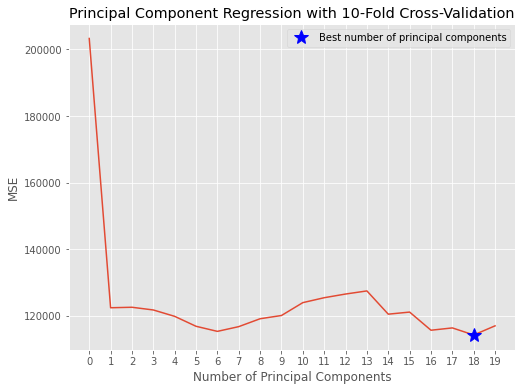

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []
for n_pc in range(0, pca.n_components_ + 1):
    if n_pc == 0:
        X_regr = np.ones((len(y),1))
    else:
        X_regr = X_reduced[:, :n_pc]
    scores = cross_val_score(regr, X_regr, y, cv=kf, scoring='neg_mean_squared_error')
    mse.append(scores.mean() * (-1))

min_mse = min(mse)
min_mse_idx = mse.index(min_mse)    
    
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(mse)
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse_idx, min_mse, 'b*', markersize=15)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Principal Component Regression with 10-Fold Cross-Validation')
plt.legend([min_mse_marker], ['Best number of principal components'])
plt.show()

In [ ]:
evr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print("Explained Variance Ratio:")
display(pd.Series([str(p) + ' %' for p in evr]))

Explained Variance Ratio:


0                  38.31 %
1     60.150000000000006 %
2                  70.84 %
3                  79.03 %
4                  84.29 %
5      88.63000000000001 %
6                  92.26 %
7      94.96000000000001 %
8                  96.28 %
9                  97.25 %
10                 97.97 %
11                 98.64 %
12                 99.14 %
13                 99.46 %
14     99.72999999999999 %
15                 99.88 %
16     99.94999999999999 %
17     99.97999999999999 %
18                 99.99 %
dtype: object

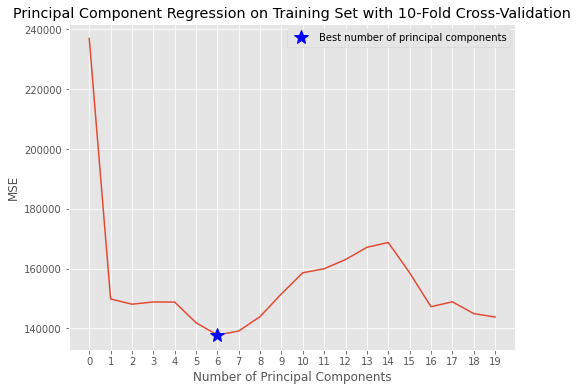

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train_reduced = pca.fit_transform(scale(X_train))

kf = KFold(n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []
for n_pc in range(0, pca.n_components_ + 1):
    if n_pc == 0:
        X_regr = np.ones((len(y_train),1))
    else:
        X_regr = X_train_reduced[:, :n_pc]
    scores = cross_val_score(regr, X_regr, y_train, cv=kf, scoring='neg_mean_squared_error')
    mse.append(scores.mean() * (-1))

min_mse = min(mse)
min_mse_idx = mse.index(min_mse)    
    
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(mse)
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse_idx, min_mse, 'b*', markersize=15)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Principal Component Regression on Training Set with 10-Fold Cross-Validation')
plt.legend([min_mse_marker], ['Best number of principal components'])
plt.show()

In [ ]:
X_test_reduced = pca.transform(scale(X_test))[:,:7]

regr = LinearRegression()
regr.fit(X_train_reduced[:,:7], y_train)

y_pred = regr.predict(X_test_reduced)
print("Test set MSE = ", mean_squared_error(y_test, y_pred))

Test set MSE =  111994.42273636989


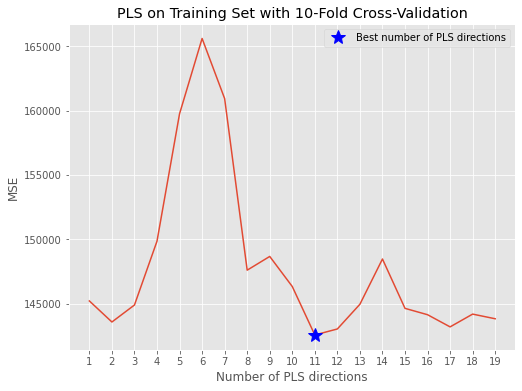

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
mse = []
for i in range(1, 20):
    pls = PLSRegression(n_components=i)
    scores = cross_val_score(pls, scale(X_train), y_train, cv=kf, scoring='neg_mean_squared_error')
    mse.append(scores.mean() * (-1))

min_mse = min(mse)
min_mse_idx = mse.index(min_mse) + 1

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, 20), mse)
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse_idx, min_mse, 'b*', markersize=15)
plt.xlabel('Number of PLS directions')
plt.ylabel('MSE')
plt.title('PLS on Training Set with 10-Fold Cross-Validation')
plt.legend([min_mse_marker], ['Best number of PLS directions'])
plt.show()

In [ ]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104838.51042760801